# Project 4: Final Project - Random Acts of Pizza
### Predicting altruism through free pizza

This project is originated from the Kaggle competition https://www.kaggle.com/c/random-acts-of-pizza. We will create an algorithm to predict which requests will recieve pizza and which on will not.  The competition contains a dataset with 5671 textual requests for pizza from the Reddit community Random Acts of Pizza together with their outcome (successful/unsuccessful) and meta-data. This data was collected and graciously shared by Althoff et al (http://www.timalthoff.com/). 

**Reference Paper:**
Tim Althoff, Cristian Danescu-Niculescu-Mizil, Dan Jurafsky. How to Ask for a Favor: A Case Study on the Success of Altruistic Requests, Proceedings of ICWSM, 2014. (http://cs.stanford.edu/~althoff/raop-dataset/altruistic_requests_icwsm.pdf)

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
from pandas.tseries.holiday import USFederalHolidayCalendar

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

# SK-learn libraries for model selection 
from sklearn.model_selection import train_test_split

# json libraries to parse json file
import json
from pandas.io.json import json_normalize

/Users/arthur/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/arthur/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# read json file
train_json = json.load(open('train.json'))

# normalize data and put in a dataframe
train_json_df = json_normalize(train_json)

# read json file
test_json = json.load(open('test.json'))

# normalize data and put in a dataframe
test_json_df = json_normalize(test_json)

print("Train shape: ", train_json_df.shape)
print("Test shape: ", test_json_df.shape)

Train shape:  (4040, 32)
Test shape:  (1631, 17)


In [3]:
train_labels = train_json_df['requester_received_pizza']
print(train_labels.shape)


(4040,)


In [4]:
# split the training data into training data and dev data 
train_json_df, dev_data, train_labels, dev_labels = \
            train_test_split(train_json_df, train_labels, test_size=0.2, random_state=42)
    

print('training data shape:', train_json_df.shape)
print('dev data shape:', dev_data.shape)
print('train label shape:', train_labels.shape)
print('dev label shape:', dev_labels.shape)
#print('test data shape:', test_data.shape)

training data shape: (3232, 32)
dev data shape: (808, 32)
train label shape: (3232,)
dev label shape: (808,)


In [5]:
# Since we want to predict whether a request will be fulfilled in realtime, we only need the *_at_request columns
train_json_df= train_json_df.drop(['number_of_downvotes_of_request_at_retrieval', 'number_of_upvotes_of_request_at_retrieval',
                           'request_number_of_comments_at_retrieval', 'requester_account_age_in_days_at_retrieval',
                           'requester_days_since_first_post_on_raop_at_retrieval', 'requester_number_of_comments_at_retrieval',
                           'requester_number_of_comments_in_raop_at_retrieval', 'requester_number_of_posts_at_retrieval',
                           'requester_number_of_posts_on_raop_at_retrieval', 'requester_upvotes_minus_downvotes_at_retrieval',
                           'requester_upvotes_plus_downvotes_at_retrieval'], axis = 1)

dev_data= dev_data.drop(['number_of_downvotes_of_request_at_retrieval', 'number_of_upvotes_of_request_at_retrieval',
                           'request_number_of_comments_at_retrieval', 'requester_account_age_in_days_at_retrieval',
                           'requester_days_since_first_post_on_raop_at_retrieval', 'requester_number_of_comments_at_retrieval',
                           'requester_number_of_comments_in_raop_at_retrieval', 'requester_number_of_posts_at_retrieval',
                           'requester_number_of_posts_on_raop_at_retrieval', 'requester_upvotes_minus_downvotes_at_retrieval',
                           'requester_upvotes_plus_downvotes_at_retrieval'], axis = 1)

#### Baseline

In [6]:
train_json_df = train_json_df.drop(['request_text','requester_received_pizza',
                            'giver_username_if_known', 'post_was_edited',
                            'request_id', 'request_text_edit_aware',
                            'request_title',
                            'requester_subreddits_at_request',
                            'unix_timestamp_of_request_utc',
                            'unix_timestamp_of_request',
                            'requester_username', 'requester_user_flair'], axis = 1)
dev_data = dev_data.drop(['request_text','requester_received_pizza',
                            'giver_username_if_known', 'post_was_edited',
                            'request_id', 'request_text_edit_aware',
                            'request_title',
                            'requester_subreddits_at_request',
                            'unix_timestamp_of_request_utc',
                            'unix_timestamp_of_request',
                            'requester_username', 'requester_user_flair'], axis = 1)

In [7]:
lr = LogisticRegression()
lr.fit(train_json_df, train_labels)

dev_preds = lr.predict(dev_data)
dev_probs = lr.predict_proba(dev_data)
dev_AUC = metrics.roc_auc_score(dev_labels, dev_probs[:,1])

print("dev AUC:", "{:.3f}".format(dev_AUC))

dev AUC: 0.603


### EDA

In [6]:
# Adding time features
train_json_df['date'] = pd.to_datetime(train_json_df["unix_timestamp_of_request_utc"], unit = 's')
dev_data['date'] = pd.to_datetime(dev_data["unix_timestamp_of_request_utc"], unit = 's')

# Add month
train_json_df['month'] = train_json_df['date'].dt.month
dev_data['month'] = dev_data['date'].dt.month

# Add hour
train_json_df['hour'] = train_json_df['date'].dt.hour
dev_data['hour'] = dev_data['date'].dt.hour

# Add weekday
train_json_df['day_of_week'] = train_json_df['date'].dt.weekday
dev_data['day_of_week'] = dev_data['date'].dt.weekday

# Add portion of month - first 15 days seems to have higher fulfillment rates

# May need to turn these features into dummy variables for every hour, every day of the week

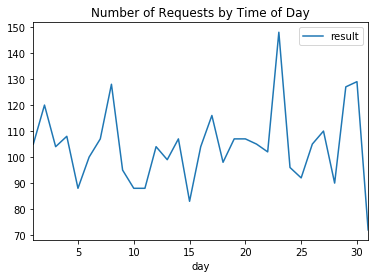

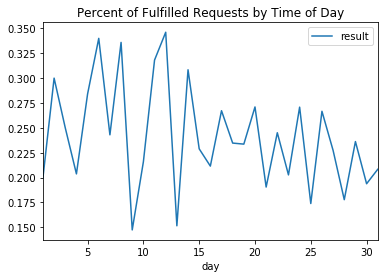

In [7]:
df = pd.DataFrame()
df['day']=train_json_df['date'].dt.day
df['result'] = train_json_df["requester_received_pizza"]
df['day', 'result'] = df.groupby('day').count().plot().set_title('Number of Requests by Time of Day')
df['day', 'result'] = df.groupby('day').mean().plot().set_title('Percent of Fulfilled Requests by Time of Day')

In [14]:
# Look at other metadata and see if there are significant differences between fullfilled and unfulfilled requests
def mean_calc(feature):
    print(feature)
    print('Fulfilled Mean: ' + str(round(train_json_df[feature][train_labels].mean(),2)))
    print('Unfulfilled Mean: ' + str(round(train_json_df[feature][np.logical_not(train_labels)].mean(),2)) + '\n')

# Create new df with just the features that have numeric values
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_feat = train_json_df.select_dtypes(include=numerics)

for feat in numeric_feat.columns.values:
    mean_calc(feat)


requester_account_age_in_days_at_request
Fulfilled Mean: 272.75
Unfulfilled Mean: 248.47

requester_days_since_first_post_on_raop_at_request
Fulfilled Mean: 28.12
Unfulfilled Mean: 13.31

requester_number_of_comments_at_request
Fulfilled Mean: 119.44
Unfulfilled Mean: 109.8

requester_number_of_comments_in_raop_at_request
Fulfilled Mean: 1.35
Unfulfilled Mean: 0.39

requester_number_of_posts_at_request
Fulfilled Mean: 24.12
Unfulfilled Mean: 21.19

requester_number_of_posts_on_raop_at_request
Fulfilled Mean: 0.14
Unfulfilled Mean: 0.04

requester_number_of_subreddits_at_request
Fulfilled Mean: 19.31
Unfulfilled Mean: 17.66

requester_upvotes_minus_downvotes_at_request
Fulfilled Mean: 1394.78
Unfulfilled Mean: 1065.77

requester_upvotes_plus_downvotes_at_request
Fulfilled Mean: 5329.09
Unfulfilled Mean: 3194.45

unix_timestamp_of_request
Fulfilled Mean: 1338236697.99
Unfulfilled Mean: 1343968092.9

unix_timestamp_of_request_utc
Fulfilled Mean: 1338233737.08
Unfulfilled Mean: 1343964922.

#### Features of importance:
##### requester_account_age_in_days_at_request: 
successful accounts are older

##### requester_days_since_first_post_on_raop_at_request:
successful accounts aren’t as frequent of posters as their counterparts

##### requester_number_of_comments_at_request, requester_number_of_comments_in_raop_at_request
successful accounts are more active commentators in general and within RAOP

##### requester_number_of_posts_on_raop_at_request
successful accounts have posted less on RAOP than their counterparts

##### requester_number_of_subreddits_at_request, requester_upvotes_minus_downvotes_at_request, requester_upvotes_plus_downvotes_at_request
successful accounts are more active AND more supportive than their counterparts

In [15]:
# Calculate user activity on raop in relation to overall Reddit activity
train_json_df['comment_ratio']= train_json_df['requester_number_of_comments_in_raop_at_request']/train_json_df['requester_number_of_comments_at_request']
train_json_df['post_ratio']=train_json_df['requester_number_of_posts_on_raop_at_request']/train_json_df['requester_number_of_posts_at_request']


# Calculate number of upvotes and downvotes
train_json_df['upvotes'] = train_json_df['requester_upvotes_plus_downvotes_at_request']+ train_json_df['requester_upvotes_minus_downvotes_at_request']/2
train_json_df['downvotes'] = train_json_df['requester_upvotes_plus_downvotes_at_request'] - train_json_df['upvotes']

# Calculate upvote to downvote ratio
train_json_df['upvotes ratio'] = train_json_df['upvotes']/train_json_df['requester_upvotes_plus_downvotes_at_request']

In [9]:
train_json_df['requester_number_of_comments_at_request'].describe()

count    3232.000000
mean      112.135210
std       189.987043
min         0.000000
25%         0.000000
50%        22.000000
75%       134.000000
max       994.000000
Name: requester_number_of_comments_at_request, dtype: float64

In [10]:
train_json_df['requester_number_of_posts_at_request'].describe()

count    3232.000000
mean       21.896349
std        51.810980
min         0.000000
25%         0.000000
50%         4.000000
75%        22.000000
max       867.000000
Name: requester_number_of_posts_at_request, dtype: float64

In [11]:
train_json_df['requester_upvotes_plus_downvotes_at_request'].describe()

count    3.232000e+03
mean     3.711598e+03
std      2.512499e+04
min      0.000000e+00
25%      7.000000e+00
50%      3.345000e+02
75%      2.277250e+03
max      1.286864e+06
Name: requester_upvotes_plus_downvotes_at_request, dtype: float64

In [16]:
# Since some of the denominators are zero, use average ratio for all infinity and null values 
train_json_df.loc[train_json_df['comment_ratio'] == np.inf, 'comment_ratio'] = train_json_df.loc[train_json_df['comment_ratio'] != np.inf, 'comment_ratio'].mean(skipna = True)
    
train_json_df.loc[pd.isnull(train_json_df['comment_ratio']), 'comment_ratio'] = train_json_df.loc[pd.notnull(train_json_df['comment_ratio']), 'comment_ratio'].mean(skipna = True)

train_json_df.loc[train_json_df['post_ratio'] == np.inf, 'post_ratio'] = train_json_df.loc[train_json_df['post_ratio'] != np.inf, 'post_ratio'].mean(skipna = True)
    
train_json_df.loc[pd.isnull(train_json_df['post_ratio']), 'post_ratio'] = train_json_df.loc[pd.notnull(train_json_df['post_ratio']), 'post_ratio'].mean(skipna = True)

train_json_df.loc[train_json_df['upvotes ratio'] == np.inf, 'upvotes ratio'] = train_json_df.loc[train_json_df['upvotes ratio'] != np.inf, 'upvotes ratio'].mean(skipna = True)
    
train_json_df.loc[pd.isnull(train_json_df['upvotes ratio']), 'upvotes ratio'] = train_json_df.loc[pd.notnull(train_json_df['upvotes ratio']), 'upvotes ratio'].mean(skipna = True)

In [17]:
# Do the same for dev_data
dev_data['comment_ratio']= dev_data['requester_number_of_comments_in_raop_at_request']/dev_data['requester_number_of_comments_at_request']
dev_data['post_ratio']=dev_data['requester_number_of_posts_on_raop_at_request']/dev_data['requester_number_of_posts_at_request']
dev_data['upvotes'] = dev_data['requester_upvotes_plus_downvotes_at_request']+ dev_data['requester_upvotes_minus_downvotes_at_request']/2
dev_data['downvotes'] = dev_data['requester_upvotes_plus_downvotes_at_request'] - dev_data['upvotes']
dev_data['upvotes ratio'] = dev_data['upvotes']/dev_data['requester_upvotes_plus_downvotes_at_request']

dev_data.loc[dev_data['comment_ratio'] == np.inf, 'comment_ratio'] = dev_data.loc[dev_data['comment_ratio'] != np.inf, 'comment_ratio'].mean(skipna = True)
    
dev_data.loc[pd.isnull(dev_data['comment_ratio']), 'comment_ratio'] = dev_data.loc[pd.notnull(dev_data['comment_ratio']), 'comment_ratio'].mean(skipna = True)

dev_data.loc[dev_data['post_ratio'] == np.inf, 'post_ratio'] = dev_data.loc[dev_data['post_ratio'] != np.inf, 'post_ratio'].mean(skipna = True)
    
dev_data.loc[pd.isnull(dev_data['post_ratio']), 'post_ratio'] = dev_data.loc[pd.notnull(dev_data['post_ratio']), 'post_ratio'].mean(skipna = True)

dev_data.loc[dev_data['upvotes ratio'] == np.inf, 'upvotes ratio'] = dev_data.loc[dev_data['upvotes ratio'] != np.inf, 'upvotes ratio'].mean(skipna = True)
    
dev_data.loc[pd.isnull(dev_data['upvotes ratio']), 'upvotes ratio'] = dev_data.loc[pd.notnull(dev_data['upvotes ratio']), 'upvotes ratio'].mean(skipna = True)

#### Text Field Analyses

In [ ]:
# Look at punctuation, words

In [18]:
# Get number of words in title
train_json_df['title_length'] = train_json_df['request_title'].apply(lambda x: len(word_tokenize(x)))
mean_calc('title_length')

title_length
Fulfilled Mean: 16.8
Unfulfilled Mean: 16.48



In [19]:
# Get number of words in request text
train_json_df['request_text_length'] = train_json_df['request_text_edit_aware'].apply(lambda x: len(word_tokenize(x)))
mean_calc('request_text_length')

request_text_length
Fulfilled Mean: 103.95
Unfulfilled Mean: 83.14



While there doesn't seem like there's much of a difference in title length between fulfilled and unfulfilled requests, request text length seems to differ quite a bit. Thus, we should add this feature.

In [20]:
dev_data['request_text_length'] = dev_data['request_text_edit_aware'].apply(lambda x: len(word_tokenize(x)))

In [21]:
train_json_df['request_num_sent'] = train_json_df['request_text_edit_aware'].apply(lambda x: len(sent_tokenize(x)))
mean_calc('request_num_sent')

request_num_sent
Fulfilled Mean: 5.6
Unfulfilled Mean: 4.67



In [22]:
dev_data['request_num_sent'] = dev_data['request_text_edit_aware'].apply(lambda x: len(sent_tokenize(x)))

In [26]:
train_df.columns.values

array(['giver_username_if_known', 'post_was_edited', 'request_id',
       'request_text', 'request_text_edit_aware', 'request_title',
       'requester_account_age_in_days_at_request',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_subreddits_at_request',
       'requester_received_pizza', 'requester_subreddits_at_request',
       'requester_upvotes_minus_downvotes_at_request',
       'requester_upvotes_plus_downvotes_at_request',
       'requester_user_flair', 'requester_username',
       'unix_timestamp_of_request', 'unix_timestamp_of_request_utc',
       'date', 'month', 'hour', 'day_of_week', 'weekend', 'comment_ratio',
       'post_ratio', 'upvotes', 'downvotes', 'upvotes ratio',
       'title_length', 'request_text_length', 'request

In [23]:
train_data = train_json_df.drop(['request_text', 'title_length','requester_received_pizza',
                            'giver_username_if_known', 'post_was_edited',
                            'request_id', 'request_text_edit_aware',
                            'request_title',
                            'requester_subreddits_at_request',
                            'unix_timestamp_of_request_utc',
                            'unix_timestamp_of_request',
                            'requester_username', 'requester_user_flair',
                            'date'
                            ],
                           axis = 1)

dev_data = dev_data.drop(['request_text', 'requester_received_pizza',
                            'giver_username_if_known', 'post_was_edited',
                            'request_id', 'request_text_edit_aware',
                            'request_title',
                            'requester_subreddits_at_request',
                            'unix_timestamp_of_request_utc',
                            'unix_timestamp_of_request',
                            'requester_username', 'requester_user_flair',
                            'date'
                            ],
                           axis = 1)

In [24]:
train_data.shape

(3232, 20)

In [25]:
dev_data.shape

(808, 20)

In [26]:
dev_data.isnull().sum()

requester_account_age_in_days_at_request              0
requester_days_since_first_post_on_raop_at_request    0
requester_number_of_comments_at_request               0
requester_number_of_comments_in_raop_at_request       0
requester_number_of_posts_at_request                  0
requester_number_of_posts_on_raop_at_request          0
requester_number_of_subreddits_at_request             0
requester_upvotes_minus_downvotes_at_request          0
requester_upvotes_plus_downvotes_at_request           0
month                                                 0
hour                                                  0
day_of_week                                           0
weekend                                               0
comment_ratio                                         0
post_ratio                                            0
upvotes                                               0
downvotes                                             0
upvotes ratio                                   

In [27]:
lr = LogisticRegression()
lr.fit(train_data, train_labels)

dev_preds = lr.predict(dev_data)
dev_probs = lr.predict_proba(dev_data)
dev_AUC = metrics.roc_auc_score(dev_labels, dev_probs[:,1])

print("dev AUC:", "{:.3f}".format(dev_AUC))

dev AUC: 0.620


In [23]:
# create MultinomialNB
nb = MultinomialNB()
    
# test the best value for alpha
#parameters = {'alpha': np.linspace(0.01, 10, 100)}

# create GridSearchCV to find the best alpha
#clf = GridSearchCV(nb, parameters)
    
# train the MultinomialNB
nb.fit(train_data, train_labels)

pred_dev_prob = nb.predict_proba(dev_data)[:,0]

print(nb.best_params_)
print("auc score using CountVectorizer & MultinomialNB = {}".format(roc_auc_score(dev_labels, pred_dev_prob, average='micro')))

/Users/arthur/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: Input X must be non-negative

In [33]:
# Filter our stopwords in request text
filtered_sent = []
for text in train_json_df['request_text_edit_aware']:
    stop_words = set(stopwords.words("english"))
    words = word_tokenize(text)
    filtered = []
    for w in words:
        if w not in stop_words:
            filtered.append(w)
    filtered_sent.append(filtered)
train_json_df['filtered'] = filtered_sent


giver_username_if_known                                                                             N/A
post_was_edited                                                                                   False
request_id                                                                                     t3_jwijt
request_text                                          My power was out for about 3 hours earlier thi...
request_text_edit_aware                               My power was out for about 3 hours earlier thi...
request_title                                         [REQUEST] My Saturday Night: Hurricane Irene i...
requester_account_age_in_days_at_request                                                        5.81191
requester_days_since_first_post_on_raop_at_request                                                    0
requester_number_of_comments_at_request                                                              58
requester_number_of_comments_in_raop_at_request                 

In [52]:
# Stemming
from nltk.stem import PorterStemmer
ps = PorterStemmer()
for l in train_json_df['filtered'][2:3]:
    for word in l:
        print(ps.stem(word))

I
'm
lucki
internet
come
part
parcel
rent
.
I
work
retail
groceri
summer
hour
murder
wallet
.
I
hustl
manag
get
good
20-25
hour
week
,
I
use
push
part
time
hour
limit
.
I
hate
beg
,
stomach
scof
call
proud
asshol
.
So
I
:
)
.
just
one
I
ask
.
